## Bayesian Optimisation Verification

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from scipy.interpolate import interp1d
from scipy import interpolate
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from scipy import stats
from scipy.stats import norm
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial.distance import cdist
from scipy.optimize import fsolve
import math

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## Trial on TiOx/SiOx
Tempeature vs. S10_HF

In [ ]:
#import normal data sheet at 85 C (time:0~5000s) 
address = 'data/degradation.xlsx'
x_normal = []
y_normal = []
df = pd.read_excel(address,sheet_name = 'normal data',usecols = [0],names = None,nrows = 5000)
df_85 = df.values.tolist()
df = pd.read_excel(address,sheet_name = 'normal data',usecols = [3],names = None,nrows = 5000)
df_85L = df.values.tolist() 

#import smooth data sheet at 85 C (time:0~5000s)
address = 'data/degradation.xlsx'
df = pd.read_excel(address,sheet_name = 'smooth data',usecols = [0],names = None,nrows = 5000)
df_85s = df.values.tolist()
df = pd.read_excel(address,sheet_name = 'smooth data',usecols = [3],names = None,nrows = 5000)
df_85Ls = df.values.tolist()

In [2]:
#import normal data sheet at 120 C (time:0~5000s) 
address = 'data/degradation.xlsx'
x_normal = []
y_normal = []
df = pd.read_excel(address,sheet_name = 'normal data',usecols = [0],names = None,nrows = 5000)
df_120 = df.values.tolist()
df = pd.read_excel(address,sheet_name = 'normal data',usecols = [3],names = None,nrows = 5000)
df_120L = df.values.tolist() 

#import smooth data sheet at 120 C (time:0~5000s)
address = 'data/degradation.xlsx'
df = pd.read_excel(address,sheet_name = 'smooth data',usecols = [0],names = None,nrows = 5000)
df_120s = df.values.tolist()
df = pd.read_excel(address,sheet_name = 'smooth data',usecols = [3],names = None,nrows = 5000)
df_120Ls = df.values.tolist()

In [ ]:
# randomly select 7 points from normal data
x_normal = np.array(df_120).T
y_normal = np.array(df_li_L).T 
x_normal = x_normal.reshape((5000))
y_normal = y_normal.reshape((5000))


In [ ]:
def plot (X,X_,y_mean,y,y_cov,gp,kernel):
    #plot function
    plt.figure()
    plt.plot(X_, y_mean, 'k', lw=3, zorder=9)

    plt.fill_between(X_, y_mean - np.sqrt(np.diag(y_cov)),y_mean + np.sqrt(np.diag(y_cov)),alpha=0.5, color='k')
    plt.scatter(X[:, 0], y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
    plt.tick_params(axis='y', colors = 'white')
    plt.tick_params(axis='x', colors = 'white')
    plt.ylabel('Lifetime',color = 'white')
    plt.xlabel('Time',color = 'white')
    plt.tight_layout()

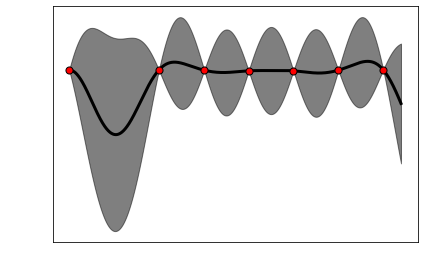

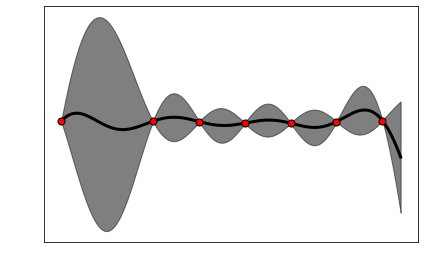

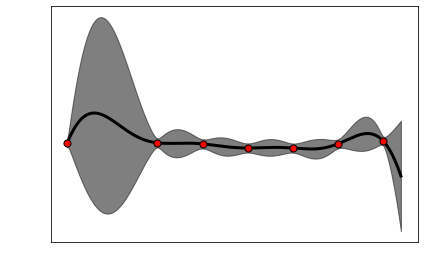

In [ ]:
# Preparing training set
# For log scaled plot
x_loop = np.array([1,10,32,100,316,1000,3162])
X = x_normal[x_loop].reshape(x_loop.size)
y = y_normal[x_loop]
X = X.reshape(x_loop.size,1)
X = np.log10(X)
MAX_x_value = np.log10(5000)
X_ = np.linspace(0,MAX_x_value, 5000)

# Kernel setting
length_scale_bounds_MAX = 0.5
length_scale_bounds_MIN = 1e-4

for length_scale_bounds_MAX in (0.3,0.5,0.7):
    kernel = 1.0 * RBF(length_scale=20,length_scale_bounds=(length_scale_bounds_MIN, length_scale_bounds_MAX)) + WhiteKernel(noise_level=0.00000001)
    gp = GaussianProcessRegressor(kernel=kernel,alpha=0.0).fit(X, y)
    y_mean, y_cov = gp.predict(X_[:, np.newaxis], return_cov=True)
    plot (X,X_,y_mean,y,y_cov,gp,kernel)

In [ ]:
# Find the minimum value in the bound
# 5000 * 5000
# Find minimum value in the last row as the minimum value for the bound

def ucb(X , gp, dim, delta):
    """
    Calculates the GP-UCB acquisition function values
    Inputs: gp: The Gaussian process, also contains all data
            x:The point at which to evaluate the acquisition function 
    Output: acq_value: The value of the aquisition function at point x
    """
    mean, var = gp.predict(X[:, np.newaxis], return_cov=True)
    #var.flags['WRITEABLE']=True
    #var[var<1e-10]=0 
    mean = np.atleast_2d(mean).T
    var = np.atleast_2d(var).T  
    beta = 2*np.log(np.power(5000,2.1)*np.square(math.pi)/(3*delta))
    return mean - np.sqrt(beta)* np.sqrt(np.diag(var))

acp_value = ucb(X_, gp, 0.1, 5)
X_min = np.argmin(acp_value[-1])

print(acp_value[-1,X_min])
print(np.argmin(acp_value[-1]))
print(min(acp_value[-1]))

0.1548936251935482
539
0.1548936251935482


-1.9993282670112766
-1.9993282670112766
653
-1.9993282670112766


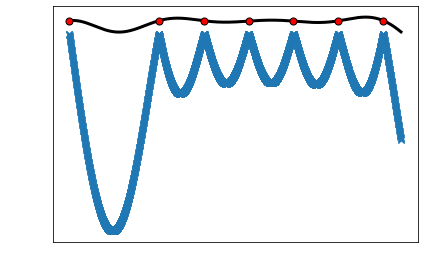

In [ ]:
# Preparing training set
x_loop = np.array([1,10,32,100,316,1000,3162])
X = x_normal[x_loop].reshape(x_loop.size)
y = y_normal[x_loop]
X = X.reshape(x_loop.size,1)
X = np.log10(X)
MAX_x_value = np.log10(5000)
X_ = np.linspace(0,MAX_x_value, 5000)

# Kernel setting
length_scale_bounds_MAX = 0.4
length_scale_bounds_MIN = 1e-4
kernel = 1.0 * RBF(length_scale=20,length_scale_bounds=(length_scale_bounds_MIN, length_scale_bounds_MAX)) + WhiteKernel(noise_level=0.0001)
gp = GaussianProcessRegressor(kernel=kernel,alpha=0.0).fit(X, y)
y_mean, y_cov = gp.predict(X_[:, np.newaxis], return_cov=True)

acp_value = ucb(X_, gp, 0.1, 5)
ucb_y_min = acp_value[-1]
print (min(ucb_y_min))
X_min = np.argmin(acp_value[-1])
print(acp_value[-1,X_min])
print(np.argmin(acp_value[-1]))
print(min(acp_value[-1]))

plt.figure()
plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
plt.plot(X_, ucb_y_min, 'x', lw=3, zorder=9)
# plt.fill_between(X_, y_mean, ucb_y_min,alpha=0.5, color='k')
plt.scatter(X[:, 0], y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.tick_params(axis='y', colors = 'white')
plt.tick_params(axis='x', colors = 'white')
plt.ylabel('Lifetime',color = 'white')
plt.xlabel('Time',color = 'white')
plt.tight_layout()


In [ ]:
acp_value = ucb(X_, gp, 0.1, 5)
X_min = np.argmin(acp_value[-1])

print(acp_value[-1,X_min])
print(np.argmin(acp_value[-1]))
print(min(acp_value[-1]))

-1.0178925921332458
618
-1.0178925921332458


-1.0178925921332458
-1.0178925921332458
[   1   10   32  100  316  618 1000 3162]


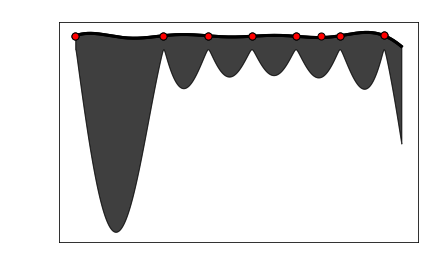

-0.8717677562444766
-0.8718694344126676
[   1   10   32  100  316  613  618 1000 3162]


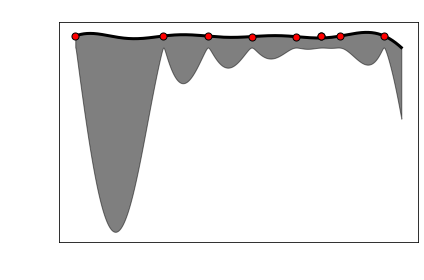

-0.8713457315591497
-0.8714492864896222
[   1   10   32  100  316  563  613  618 1000 3162]


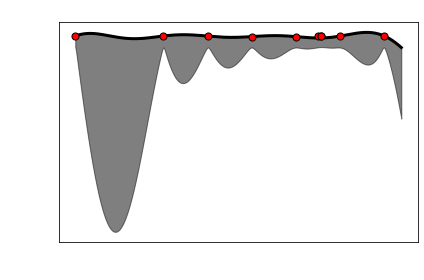

-0.8568533976009571
-0.8570101732162176
[   1   10   32  100  316  563  612  613  618 1000 3162]


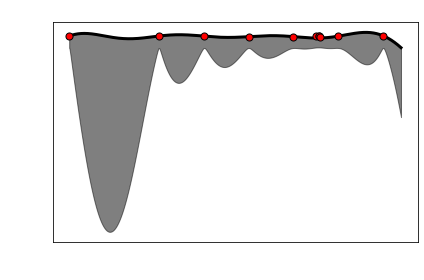

-0.85256195078217
-0.8527212263752526
[   1   10   32  100  316  562  563  612  613  618 1000 3162]


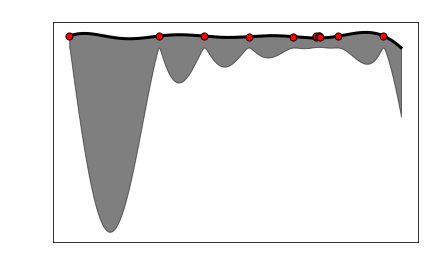

X: [[0.        ]
 [1.        ]
 [1.50514998]
 [2.        ]
 [2.49968708]
 [2.74973632]
 [2.75050839]
 [2.78675142]
 [2.78746047]
 [2.79098848]
 [3.        ]
 [3.49996187]] 
Y: [0.74522 0.74522 0.74422 0.74022 0.74022 0.74122 0.74222 0.74322 0.74222
 0.74122 0.74422 0.74722]


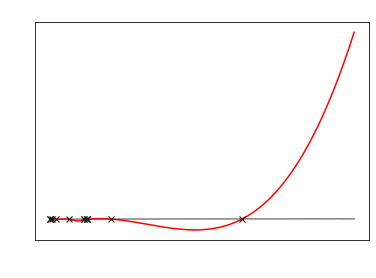

In [ ]:
# Iterate i times with mins value point of each ucb bound

# Initiate with 7 data points, apply log transformation to them
x_loop = np.array([1,10,32,100,316,1000,3162])
X = x_normal[x_loop].reshape(x_loop.size)
Y = y_normal[x_loop]
X = X.reshape(x_loop.size,1)
X = np.log10(X)
MAX_x_value = np.log10(5000)
X_ = np.linspace(0,MAX_x_value, 5000)
# Kernel setting
length_scale_bounds_MAX = 0.5
length_scale_bounds_MIN = 1e-4
kernel = 1.0 * RBF(length_scale=20,length_scale_bounds=(length_scale_bounds_MIN, length_scale_bounds_MAX)) + WhiteKernel(noise_level=0.0001)
gp = GaussianProcessRegressor(kernel=kernel,alpha=0.0).fit(X, Y)
y_mean, y_cov = gp.predict(X_[:, np.newaxis], return_cov=True)

acp_value = ucb(X_, gp, 0.1, 5)
ucb_y_min = acp_value[-1]

plt.figure()
plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
plt.fill_between(X_, y_mean, ucb_y_min,alpha=0.5, color='k')
plt.scatter(X[:, 0], Y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.tick_params(axis='y', colors = 'white')
plt.tick_params(axis='x', colors = 'white')
plt.ylabel('Lifetime',color = 'white')
plt.xlabel('Time',color = 'white')
plt.tight_layout()

# Change i to set extra data points
i=0

while i < 5 :
    acp_value = ucb(X_, gp, 0.1, 5)
    ucb_y_min = acp_value[-1]
    index = np.argmin(acp_value[-1])

    print(acp_value[-1,X_min])
    print(min(acp_value[-1]))

    # Protection to stop equal x value
    while index in x_loop:
        index = index -  50
    x_loop = np.append(x_loop, index)
    x_loop = np.sort(x_loop)

    print (x_loop)

    X = x_normal[x_loop].reshape(x_loop.size)
    Y = y_normal[x_loop]
    X = X.reshape(x_loop.size,1)
    X = np.log10(X)

    gp = GaussianProcessRegressor(kernel=kernel,alpha=0.0).fit(X, Y)

    plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
    plt.fill_between(X_, y_mean, ucb_y_min,alpha=0.5, color='k')
    plt.scatter(X[:, 0], Y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
    plt.tick_params(axis='y', colors = 'white')
    plt.tick_params(axis='x', colors = 'white')
    plt.ylabel('Lifetime',color = 'white')
    plt.xlabel('Time',color = 'white')
    plt.title('cycle %d'%(i), color = 'white')
    plt.tight_layout()
    plt.show()

    i+=1
print('X:', X, '\nY:', Y)
s = interpolate.InterpolatedUnivariateSpline(x_loop,Y)
x_uni = np.arange(0,5000,1)
y_uni = s(x_uni)
# Plot figure
plt.plot(df_120s,df_120Ls,'-',color = 'gray')
plt.plot(x_uni,y_uni,'-',color = 'red')
plt.plot(x_loop,  Y,'x',color = 'black')
plt.tick_params(axis='y', colors = 'white')
plt.tick_params(axis='x', colors = 'white')
plt.ylabel('Lifetime',color = 'white')
plt.xlabel('Time',color = 'white')
plt.title('cycle %d'%(i+1), color = 'white')


plt.show()